In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from PIL import Image
import os

In [50]:
# Custom dataset for additional images
class CustomDataset(Dataset):
    def __init__(self, img_dir, transform=None, label=0):
        self.img_dir = img_dir
        self.transform = transform
        self.images = os.listdir(img_dir)
        self.label = label

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.label

In [51]:
transform = transforms.Compose([
     transforms.Resize((32, 32)), # add Resize to match cifar image sizes
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

trainset_cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
print("CIFAR10 dataset image shape:", trainset_cifar10[0][0].shape)

testset_cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
#Add melanoma images
melanoma_dataset = CustomDataset('./isic_class/melanoma', transform=transform, label=10)
print("Melanoma dataset image shape:", melanoma_dataset[0][0].shape)

# Split in 80/20 train/test
train_size = int(0.8 * len(melanoma_dataset))
test_size = len(melanoma_dataset) - train_size
melanoma_train, melanoma_test = random_split(melanoma_dataset, [train_size, test_size])

# Combine datasets
combined_trainset = ConcatDataset([trainset_cifar10, melanoma_train])
combined_testset = ConcatDataset([testset_cifar10, melanoma_test])

#Dataloaders (i've set the num_workers to 0, to avoid crashing jupyter)
trainloader = torch.utils.data.DataLoader(combined_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(combined_testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

#Add the 11th class melanoma
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'melanoma')

Files already downloaded and verified
CIFAR10 dataset image shape: torch.Size([3, 32, 32])
Files already downloaded and verified
Melanoma dataset image shape: torch.Size([3, 32, 32])


In [52]:
# Check the first item of the CIFAR10 dataset
cifar10_sample = next(iter(trainset_cifar10))
print("CIFAR10 sample shape:", cifar10_sample[0].shape, "Label type:", type(cifar10_sample[1]))

# Check the first item of the custom dataset
custom_sample = next(iter(melanoma_train))
print("Custom sample shape:", custom_sample[0].shape, "Label type:", type(custom_sample[1]))


CIFAR10 sample shape: torch.Size([3, 32, 32]) Label type: <class 'int'>
Custom sample shape: torch.Size([3, 32, 32]) Label type: <class 'int'>


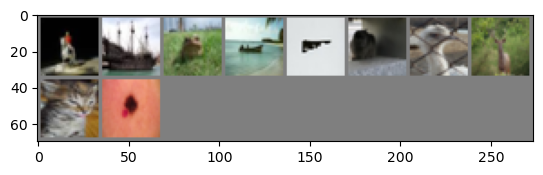

horse ship  frog  ship  plane cat   bird  deer  cat   melanoma


In [59]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 42, 5) #increasing the network size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(42, 16, 5) #increasing the network size
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 11)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [99]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#changing optimizer to ADAMW
optimizer = optim.AdamW(net.parameters(), lr=0.001)

In [100]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.693
[1,  4000] loss: 1.418
[2,  2000] loss: 1.251
[2,  4000] loss: 1.181
Finished Training


In [102]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

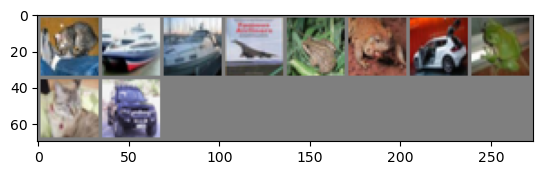

GroundTruth:  cat   ship  ship  plane


In [103]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [104]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [105]:
outputs = net(images)

In [106]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  plane plane


In [107]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 58 %


In [108]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 72.8 %
Accuracy for class: car   is 76.8 %
Accuracy for class: bird  is 21.3 %
Accuracy for class: cat   is 39.0 %
Accuracy for class: deer  is 54.6 %
Accuracy for class: dog   is 43.7 %
Accuracy for class: frog  is 67.5 %
Accuracy for class: horse is 77.9 %
Accuracy for class: ship  is 69.1 %
Accuracy for class: truck is 62.5 %
Accuracy for class: melanoma is 90.6 %
